In [3]:
#  creates shp from geojson
import geopandas as pd

gdf = pd.read_file('E:\Studia\Fotogrametria i teledetekcja]\CloudFerro_konkurs\Konkurs\AOI_1_1.geojson')
gdf.to_file('E:\Studia\Fotogrametria i teledetekcja]\CloudFerro_konkurs\Konkurs\AOI_1.shp')

In [2]:
# crates geojson file from a shp - input to the Eobrowser
import geopandas
from geopandas import datasets

path_to_data = "E:\Studia\Fotogrametria i teledetekcja]\CloudFerro_konkurs\Konkurs\AOI\AOI_kafel2.shp"
output_path = "E:\Studia\Fotogrametria i teledetekcja]\CloudFerro_konkurs\Konkurs\AOI\AOI_kafel2.geojson"
gdf = geopandas.read_file(path_to_data)

gdf.to_file(output_path, driver="GeoJSON") 

**Sentinel Hub package - authentication/token** 

In [2]:
from sentinelhub import SHConfig

config = SHConfig()
config.sh_client_id = "58f82b2a-cb49-48b6-a632-e1cb91154474"
config.sh_client_secret = "5XL370.c)|!D-haRkLqAI9A3Lg@WU3i~!*T|;il6"
config.save()

# SHConfig.get_config_location(config)

In [ ]:
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session

def sentinelhub_compliance_hook(response):
    response.raise_for_status()
    return response


# Your client credentials
# client_id = '###'
# client_secret = '###'


# Create a session
client = BackendApplicationClient(client_id=config.sh_client_id)
oauth = OAuth2Session(client=client)

# Get token for the session
token = oauth.fetch_token(token_url='https://services.sentinel-hub.com/oauth/token',
                          client_secret=config.sh_client_secret)

# All requests using this session will have an access token automatically added
resp = oauth.get("https://services.sentinel-hub.com/oauth/tokeninfo")
print(resp.content)

# oauth.register_compliance_hook("access_token_response", sentinelhub_compliance_hook)


**Large area utilities - Prerequisites - Imports**

In [3]:
%matplotlib inline

import itertools
import tempfile
from pathlib import Path

import numpy as np
from shapely.geometry import MultiLineString, MultiPolygon, Polygon, box, shape

from sentinelhub import (
    CRS,
    BBox,
    BBoxSplitter,
    CustomGridSplitter,
    DataCollection,
    MimeType,
    MosaickingOrder,
    OsmSplitter,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    TileSplitter,
    UtmGridSplitter,
    UtmZoneSplitter,
    read_data,
)

In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import rioxarray  # noqa: F401 # Its necesary for xarray.open_mfdataset() with engine `rasterio`
import xarray as xr  # It may need Dask library https://docs.dask.org/en/stable/install.html
from matplotlib.patches import Polygon as plt_polygon
from mpl_toolkits.basemap import Basemap  # Available here: https://github.com/matplotlib/basemap

****Collecting data# ****

In [1]:
# Geometry of a splitting area - creating shapaly object to fulfill the sentinelhub-py requirements
from shapely.geometry import Polygon

geo = {"type":"Polygon","coordinates":
       [[[-120.673828,57.884197],
         [-118.940735,57.884197],
         [-118.940735,58.615486],
         [-120.673828,58.615486],
         [-120.673828,57.884197]]]}
AOI = Polygon([tuple(l) for l in geo['coordinates'][0]])
type(AOI)

shapely.geometry.polygon.Polygon

**Visualizing the area of interest (optional)**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


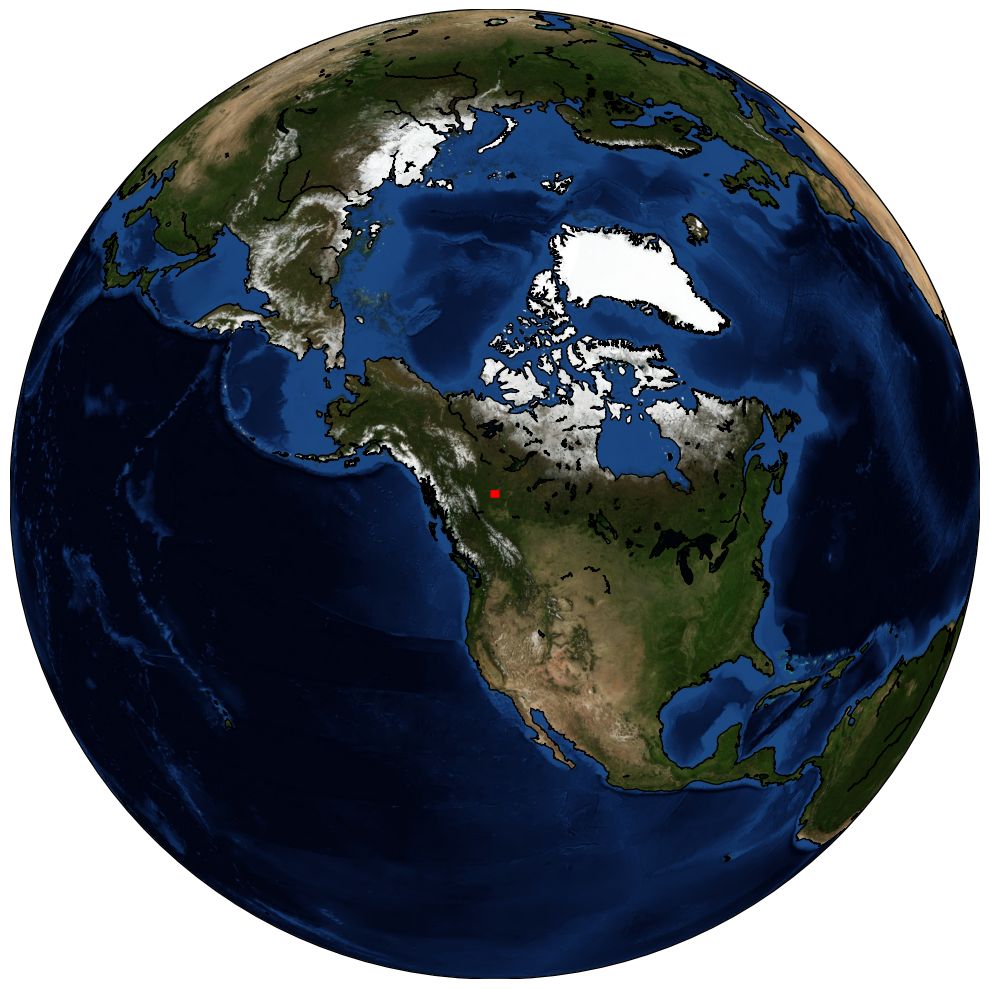

In [4]:

def show_area(area_shape, area_buffer=0.3):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)

    minx, miny, maxx, maxy = area_shape.bounds
    lng, lat = (minx + maxx) / 2, (miny + maxy) / 2

    m = Basemap(projection="ortho", lat_0=lat, lon_0=lng, resolution="l")
    m.drawcoastlines()
    m.bluemarble()

    if isinstance(area_shape, Polygon):
        polygon_iter = [area_shape]
    elif isinstance(area_shape, MultiPolygon):
        polygon_iter = area_shape.geoms
    else:
        raise ValueError(f"Geometry of type {type(area_shape)} is not supported")

    for polygon in polygon_iter:
        x, y = np.array(polygon.boundary.coords)[0]
        m_poly = []
        for x, y in np.array(polygon.boundary.coords):
            m_poly.append(m(x, y))
        ax.add_patch(plt_polygon(np.array(m_poly), closed=True, facecolor="red", edgecolor="red"))

    plt.tight_layout()
    plt.show()


show_area(AOI)

In [11]:
bbox_splitter = BBoxSplitter(
    [AOI], CRS.WGS84, (8, 4)
)  # bounding box will be split into grid of 5x4 bounding boxes

print("Area bounding box: {}\n".format(bbox_splitter.get_area_bbox().__repr__()))

bbox_list = bbox_splitter.get_bbox_list()
info_list = bbox_splitter.get_info_list()

# Prepare info of selected EOPatches
geom = [Polygon(bbox.get_polygon()) for bbox in bbox_list]
idxs_x = [info['index_x'] for info in info_list]
idxs_y = [info['index_y'] for info in info_list]

df = pd.DataFrame({'index_x':idxs_x, 'index_y':idxs_y})
gdf = gpd.GeoDataFrame(df,crs=4326, geometry=geom)
# gdf
gdf["geometry"].to_clipboard()
# gdf.to_wkt
# gdf.to_wkt().to_clipboard()
# gdf.to_file("E:\Studia\Fotogrametria i teledetekcja]\CloudFerro_konkurs\Konkurs\AOI\AOI_nowe.shp")


Area bounding box: BBox(((-120.673828, 57.884197), (-118.940735, 58.615486)), crs=CRS('4326'))

